In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import jax.numpy as np
import numpy as num
from jax import grad, jit, vmap, value_and_grad
from jax import random
import jax

import seaborn as sns
import matplotlib.pyplot as plt

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)


def plot_mnist_performance(train_loss, train_acc, test_acc,
                           sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier on MNIST """
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    axs.plot(train_loss)
    axs.set_xlabel("# Batch Updates")
    axs.set_ylabel("Batch Loss")
    axs.set_title("Training Loss")
    #for i in range(1):
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    fig.suptitle(sup_title, fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.925])

In [3]:
def ReLU(x):
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

def FiniteDiffGrad(x):
    return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2 * 1e-3))

In [4]:
def scan(init, xs, b,length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for i in range(len(xs.shape)): 
        y = np.dot(xs[i].T, carry[i, :, :]) + b[i] 
        ys.append(y) 
    return np.stack(ys)[0].sum(axis=-1)

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def relu_layer_sep(params, x): 
    return RELU(scan(params[0], x, params[1]))

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

## Работа с MNIST

In [5]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers

import torch
from torchvision import datasets, transforms

import time

In [6]:
#!pip install seaborn

In [7]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

## Общие функции

In [27]:
rng = num.random.RandomState(42)
def salimans_sample(shape):
    w = rng.normal(0,1,(shape[0],shape[1]))
    w -= np.mean(w, axis=0, keepdims=True)
    w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
    return w.astype('float64')

def _logit(x):
    """
    Logit function in Numpy. Useful for parameterizing alpha.
    """
    return np.log(x/(1. - x))

def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds, mean, logvar = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)
 
def kl_divergence(params, in_arrays, targets):
    preds, mean, logvar = batch_forward(params, in_arrays) 
    loss_total = -0.5 * np.sum(1 + logvar - mean ** 2 - np.exp(logvar)) - np.sum(preds * targets)
    return loss_total

In [28]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """ 
    value, grads = value_and_grad(kl_divergence)(params, x, y)
    opt_state = opt_update(0, grads, opt_state) 
    return get_params(opt_state), opt_state, value

In [29]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP", sampling="1"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss, train_loss_kl = [], [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            x = np.array(data).reshape(data.size(0), 28*28)
 
            y = one_hot(np.array(target), num_classes)
 
            params, opt_state, kl_loss = update(params, x, y, opt_state) 
 
            if batch_idx % 50 == 0 and sampling=="2":
                print(kl_loss)
            
            train_loss_kl.append(kl_loss)

        epoch_time = time.time() - start_time
        print("Epoch {} | T: {:0.2f} | Elbo loss: {:0.4f} |".format(epoch+1, epoch_time, num.mean(train_loss_kl)))

    return train_loss_kl, log_acc_train, log_acc_test

## Реализация метода 1(сэмплирование весов для каждого батча)

In [30]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, key, scale=1e-1):
        rng = num.random.RandomState(42)
        def salimans_sample(shape):
            w = rng.normal(0,1,(shape[0],shape[1]))
            w -= np.mean(w, axis=0, keepdims=True)
            w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
            return w.astype('float64')
        w_key, b_key = random.split(key)
        #print(w_key)
        p = 0.5
        logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
        alpha = jax.nn.sigmoid(logitalpha)
        W = salimans_sample((n, m))
        W_noised = W*(1. + random.normal(w_key, W.shape)*np.sqrt(alpha))

        #print((scale *W_noised).shape)
        return  scale *W_noised, scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 10]
params = initialize_mlp(layer_sizes, key)
#print(len(params))

/tmp/ipykernel_12282/1100379222.py:15: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
/tmp/ipykernel_12282/1100379222.py:11: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return w.astype('float64')


In [31]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array
    #print(params[0][0], params[0][1])
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)

    final_w_mean, final_b_mean = params[-1]
    final_w_logvar, final_b_logvar = params[-1]
    final_w, final_b = params[-1]
    
    mean = np.dot(final_w_mean, activations) + final_b_mean
    logvar = np.dot(final_w_logvar, activations) + final_b_logvar
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits), mean, logvar #logits - logsumexp(logits) #- logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [32]:
def kl_divergence(params, in_arrays, targets):
    preds, mean, logvar = batch_forward(params, in_arrays) 
    loss_total = -0.5 * np.sum(1 + logvar - mean ** 2 - np.exp(logvar)) - 28 * 28 * np.sum(preds * targets) 
    return loss_total

Epoch 1 | T: 9.66 | Elbo loss: 24292.2734 |
Epoch 2 | T: 9.23 | Elbo loss: 19994.9570 |
Epoch 3 | T: 9.70 | Elbo loss: 17904.7070 |
Epoch 4 | T: 9.18 | Elbo loss: 16591.1758 |
Epoch 5 | T: 9.47 | Elbo loss: 15640.6729 |


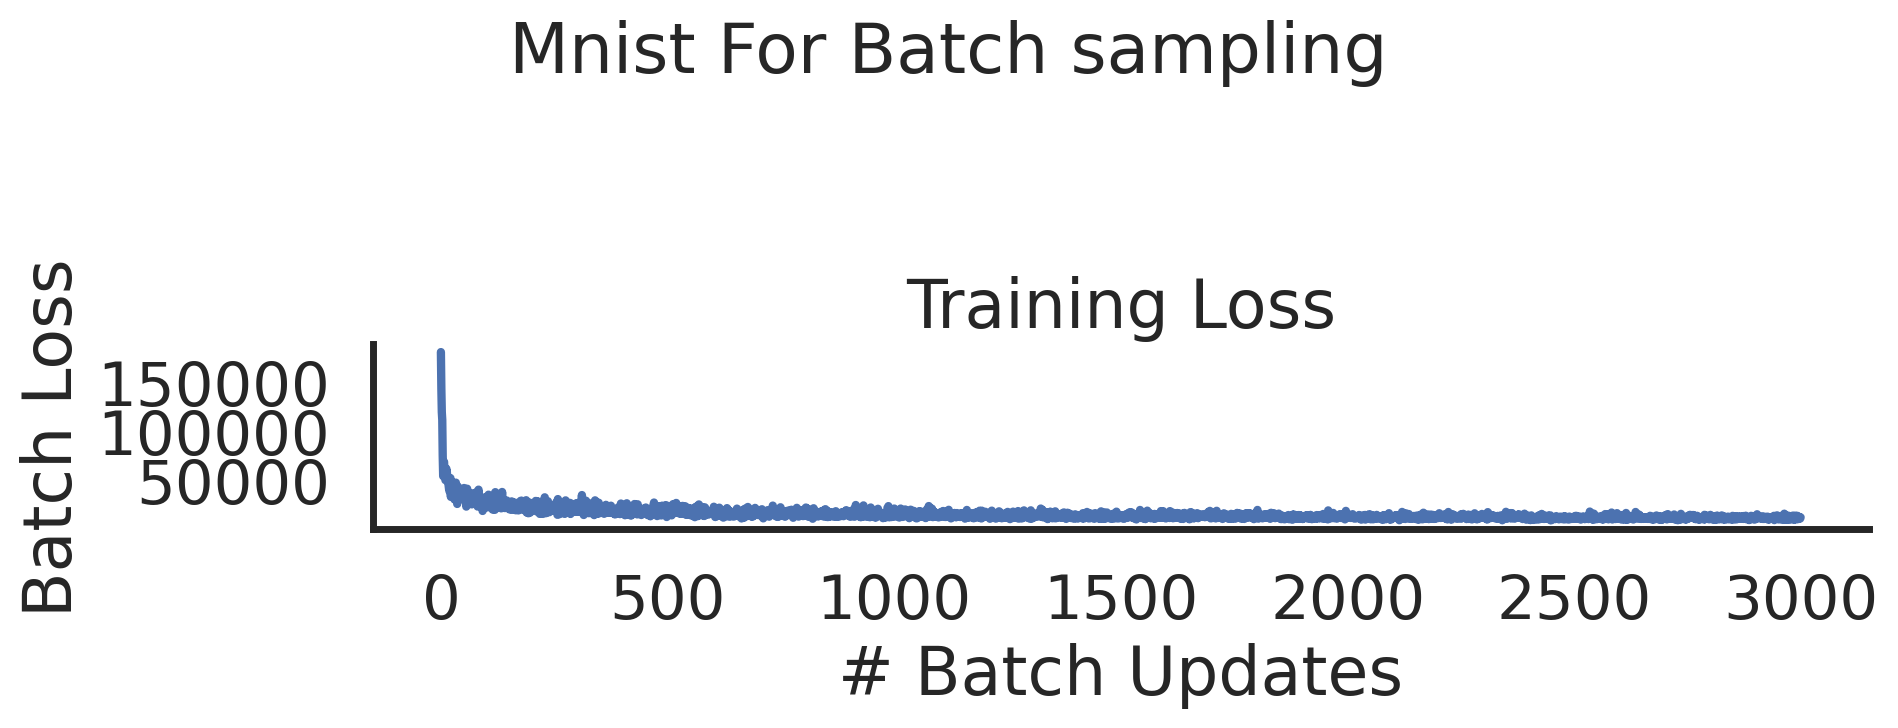

In [33]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params) 

num_epochs = 5
num_classes = 10
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")

# Plot the loss curve over time
#from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "Mnist For Batch sampling")

## Реализация метода 2(сэмплирование весов для каждого элемента батча)

In [12]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, key, scale=1e-2):
        rng = num.random.RandomState(42)
        def salimans_sample(shape):
            w = rng.normal(0,1,(shape[0],shape[1]))
            w -= np.mean(w, axis=0, keepdims=True)
            w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
            return w.astype('float64')
        w_key, b_key = random.split(key)
        #print(w_key)
        p = 0.5
        logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
        alpha = jax.nn.sigmoid(logitalpha)
        W = salimans_sample((n, m))
        #W_noised = W*(1. + random.normal(w_key, W.shape)*np.sqrt(alpha))

        W_noised = W*(1 + random.normal(w_key, (28*28,
                        W.shape[0],
                        W.shape[1]))*np.sqrt(alpha))

        #print((scale *W_noised).shape)
        return  scale *W_noised, scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
params = initialize_mlp(layer_sizes, key)
print(len(params))

/tmp/ipykernel_908/3230793244.py:15: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
/tmp/ipykernel_908/3230793244.py:11: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return w.astype('float64')


3


In [13]:
random.split(key, len(layer_sizes))

Array([[ 869452973, 4133157646],
       [ 261504626, 4112007671],
       [3597360905,  253918841],
       [  98387565,  678776088]], dtype=uint32)

In [14]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer_sep([w, b], activations)
        
    final_w_mean, final_b_mean = params[-1]
    final_w_logvar, final_b_logvar = params[-1]
    final_w, final_b = params[-1]
    
    mean = (np.dot(final_w_mean, activations) + final_b_mean).sum(axis=0)
    logvar = (np.dot(final_w_logvar, activations) + final_b_logvar).sum(axis=0)
    logits = (np.dot(final_w, activations) + final_b).sum(axis=0)
    return logits - logsumexp(logits), mean, logvar

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

Now we need some gradient-sauce: In order to get there we need to define which function we would like to optimize. This is going to be the multi-class cross-entropy loss between the one-hot encoded class labels ($y_i \in \mathbb{R}^{10}$) and the softmax output of the network ($p^\theta(x_i) \in \mathbb{R}^{10}$):

$$ - \sum_{c=1}^{10} y_{ic} \log p^\theta_{c}(x_i) $$

Finally, for logging purposes we compute the accuracy as well.

570252800.0
3957.7983
3674.273
3619.3372
3556.1035
3488.4692
3430.4446
3391.435
3346.1826
3297.3203
3285.6265
3236.09
Epoch 1 | T: 1822.10 | Elbo loss: 1659685.3750 |
3196.6284
3184.7378
3172.5713
3158.5872
3129.4478
3126.1064
3103.3813
3102.439
3079.2964
3077.3188
3053.5508
3054.2744
Epoch 2 | T: 1857.85 | Elbo loss: 831401.1875 |
3048.588
3058.7583
3016.7878
3006.6287
3002.5332
3015.9736
3011.3936
2994.7422
2966.557
2950.265
2967.4167
2954.06
Epoch 3 | T: 1876.32 | Elbo loss: 555265.6250 |
2929.915
2920.0586
2917.8242
2922.203
2900.574
2890.1
2879.9805
2872.3447
2847.7222
2861.157
2835.9712
2812.858
Epoch 4 | T: 1887.05 | Elbo loss: 417168.6875 |
2808.6504
2806.9346
2787.708
2772.9124
2748.275
2753.8142
2751.3733
2731.0376
2703.3372
2682.495
2654.8135
2676.921
Epoch 5 | T: 1892.69 | Elbo loss: 334282.0000 |


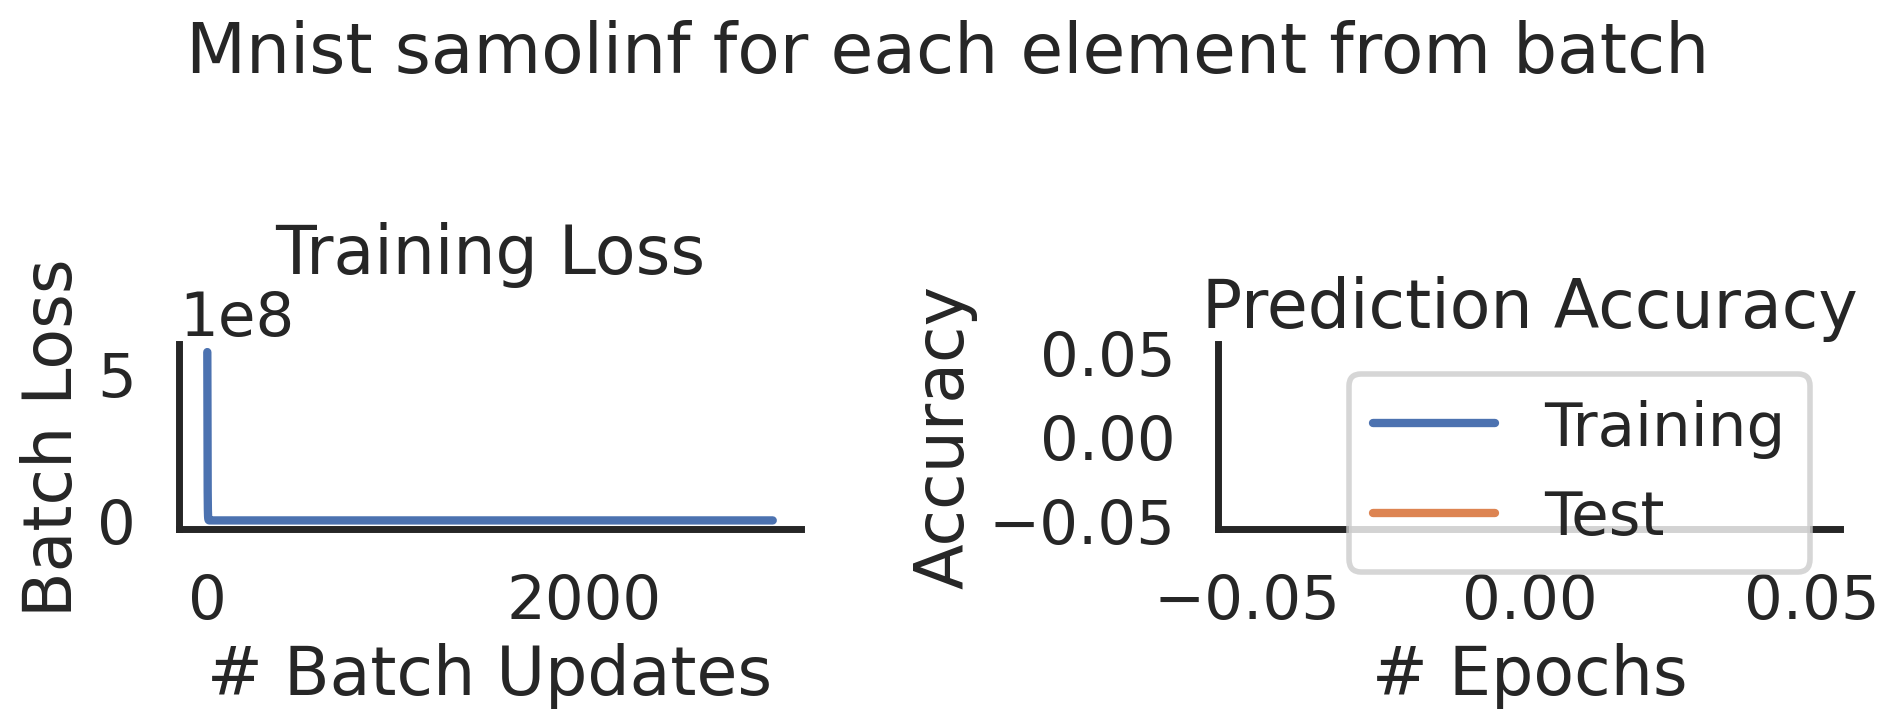

In [15]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 5
num_classes = 10
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP",
                                                          sampling ="2")

# Plot the loss curve over time
from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "Mnist samolinf for each element from batch")

### учится долго, поэтому тут не убран ненужный график, не хотелось еще запускать еще на 2 часа:)

## Local Reparametrization

In [41]:
from flax import linen as nn

In [42]:
#!pip install flax

In [51]:
from typing import Sequence, Callable

class MultiLayerPerceptron(nn.Module):
    p = 0.5
    hidden_neurons: Sequence[int]
    kernel_init: Callable = nn.initializers.lecun_normal()
    activation: Callable = nn.sigmoid
    logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')
    alpha = jax.nn.sigmoid(logitalpha)
    llayer = nn.Dense(features=10)
    
    def new_linear(self,x, neurons):
        theta = self.kernel_init(jax.random.PRNGKey(42), x.shape, np.float64)
        mu_z = x 
        sigma_z = np.sqrt(np.dot(np.square(x[1]), self.alpha*np.square(theta)[0]))
        randn = num.random.normal(size=x[0].shape) 
        return mu_z + sigma_z*randn
    
    @nn.compact
    def __call__(self, x): 
        for k, neurons in enumerate(self.hidden_neurons):
            #x = nn.Dense(neurons, kernel_init=self.kernel_init)(x)
            x = self.new_linear(x, neurons)
            #print(x.shape)
            if k != len(self.hidden_neurons) - 1:
                x = self.activation(x)
            #x = self.new_linear(x, neurons)
        return x

/tmp/ipykernel_11641/2077358461.py:8: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  logitalpha = np.array(_logit(np.sqrt(p/(1.-p)))).astype('float64')


In [52]:
class MLP(nn.Module): 
    @nn.compact
    def __call__(self, x):
        x = MultiLayerPerceptron([748, 512], activation=nn.tanh)(x)
        #print(x.shape)
        mean = nn.Dense(features=10)(x)
        logvar = nn.Dense(features=10)(x)
        logits = nn.Dense(features=10)(x)
        #print(mean.shape)
        return logits, mean, logvar

In [53]:
import optax
from flax.training import train_state


def create_train_state(rng):
    """Creates initial `TrainState`."""
    param_rng, z_rng = jax.random.split(rng)

    mlp = MLP()
    params = mlp.init(param_rng, np.ones([1, 28 * 28]))['params']
    tx = optax.adam(0.001)
    return train_state.TrainState.create(
    apply_fn=mlp.apply, params=params, tx=tx)

rng = jax.random.PRNGKey(42)
state = create_train_state(rng)
def get_mlp(params, x):
    logits, mean, logvar = state.apply_fn({'params': params['params']}, x)
    return logits, mean, logvar

In [54]:
mlp = MLP()
#batch_forward = vmap(get_mlp, in_axes=(None, 0), out_axes=0)

In [55]:
#!pip install jax_metrics

In [56]:
def kl_divergence(params, in_arrays, targets, loss='1'):
    #print('ok')
    preds, mean, logvar = get_mlp(params, in_arrays)  
    loss_total = -0.5 * np.sum(1 + logvar - mean ** 2 - np.exp(logvar)) - np.sum(preds * targets) #- np.sum(preds * targets)
    #print(loss_total)
    return loss_total

In [57]:
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    #grad_fn = jax.value_and_grad(kl_divergence, has_aux=True)
    #value, grads = grad_fn(params)
    value, grads = value_and_grad(kl_divergence)(params, x, y) #loss
    opt_state = opt_update(0, grads, opt_state) 
    return get_params(opt_state), opt_state, value

Epoch 1 | T: 22.71 | Elbo loss: 12544.7021 |
Epoch 2 | T: 22.68 | Elbo loss: 10645.3096 |
Epoch 3 | T: 22.30 | Elbo loss: 8492.5557 |
Epoch 4 | T: 22.49 | Elbo loss: 6980.5327 |
Epoch 5 | T: 22.16 | Elbo loss: 6152.1479 |


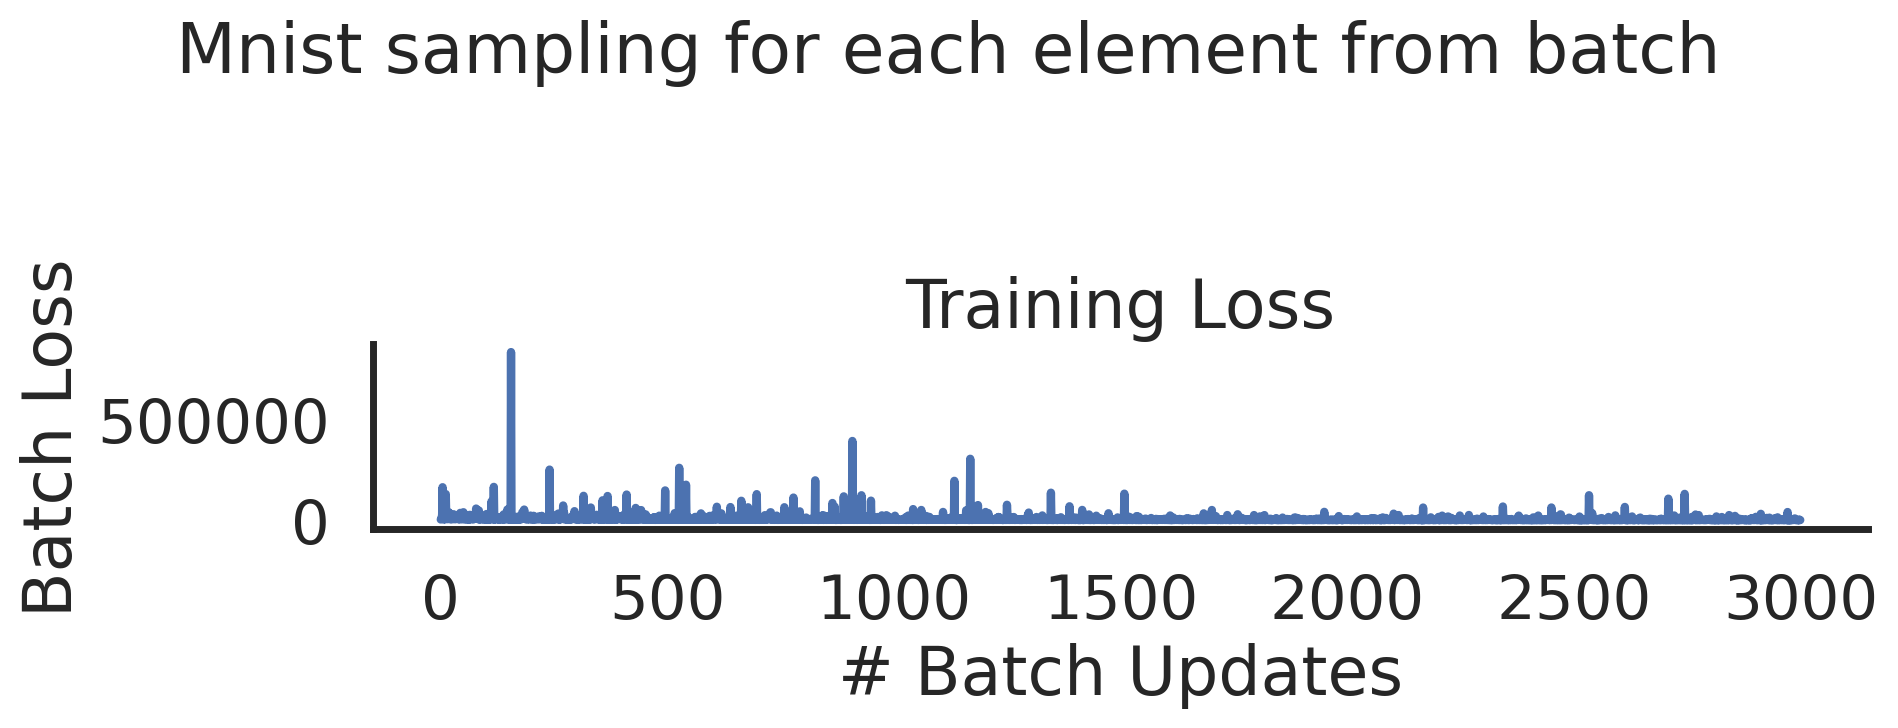

In [58]:
step_size = 1e-3
params = mlp.init(random.PRNGKey(42), np.ones([1, 28 * 28]))
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
#params = mlp.init(random.PRNGKey(42), np.ones([1, 28 * 28]))
num_epochs = 5
num_classes = 10
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP",
                                                          sampling ="1")

# Plot the loss curve over time
#from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "Mnist sampling for each element from batch")

### Вывод

##### Реализованы три метода по различным стратегиям по сэмплированию в нейронных моделях. Но тут можно еще дорабатывать. Но к сожалению, не успела(( Но лосс в последнем случае самый наименьший(~1.4*10^(4))